In [1]:
import scipy.io
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
import keras
from keras import layers as Layer
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Using TensorFlow backend.


Extract the bounding box coordinate from mat format file

In [2]:
def extract_mat_contents(annot_directory, image_dir):
    # Create MAT Parser
    mat = scipy.io.loadmat(annot_directory)
    # Get the height and width for our image
    height, width = cv2.imread(image_dir).shape[:2]
    # Get the bounding box co-ordinates
    x1, y2, y1, x2 = mat['box_coord'][0]
    class_name = annot_directory.split('/')[-1].split('\\')[-2]
    filename = image_dir.split('/')[-1].split('\\')[-1]
    
    return  filename, width, height, class_name, x1, y2, y1, x2

In [3]:
def mat_to_csv(annot_directory, image_directory, classes_folders):
    mat_content = []
    # We loop our each class and its labels one by one to preprocess and augment
    for class_folder in classes_folders:
        # Set our images and annotations directory
        image_dir = os.path.join(image_directory, class_folder)
        annot_dir = os.path.join(annot_directory, class_folder)
        # Get each file in the image and annotation directory
        mat_files = sorted(os.listdir(annot_dir))
        img_files = sorted(os.listdir(image_dir))
        # Loop over each of the image and its label
        for mat, image_file in zip(mat_files, img_files):
            # Full mat path
            mat_path = os.path.join(annot_dir, mat)
            # Full path Image
            img_path = os.path.join(image_dir, image_file)
            # Get Attributes for each image
            value = extract_mat_contents(mat_path, img_path)
            # Append the attributes to the mat_list
            mat_content.append(value)
            # Columns for Pandas DataFrame
            column_name = ['filename', 'width', 'height', 'class', 'ymin', 'ymax','xmin', 'xmax']
            # Create the DataFrame from mat_list
            mat_df = pd.DataFrame(mat_content, columns=column_name)
            # Return the dataframe

    return mat_df


Get the image and generate the dataframe for images

In [4]:
def img_csv(image_dir):
    df = pd.DataFrame(columns = ['class_name','class'])
    index = 0
    for classes in sorted(os.listdir(image_dir)):
        if 'butterfly' in classes:
            df.loc[index] = [classes,str('0')]
        elif 'cougar' in classes:
            df.loc[index] = [classes,str('1')]
        elif 'elephant' in classes:
            df.loc[index] = [classes,str('2')]
        index+=1
    return df

Start the extraction from mat files and also images

In [5]:
annot_directory = 'CALTECH/CALTECH_Annotations'
image_directory = 'CALTECH/CALTECH_Dataset'
all_image_directory = 'CALTECH/CALTECH_Dataset/all'
class_list = sorted(['butterfly', 'cougar_face', 'elephant'])
df = mat_to_csv(annot_directory, image_directory, class_list)
df.to_csv(('labels.csv'), index=None)

In [6]:
img_df = img_csv(all_image_directory)
annot_df = pd.read_csv('labels.csv')

Data preprocess, normalize the coordinate according to the width and height

In [7]:
width = annot_df['width']
height = annot_df['height']
annot_df['ymin'] = annot_df['ymin']/height
annot_df['ymax'] = annot_df['ymax']/height
annot_df['xmin'] = annot_df['xmin']/width
annot_df['xmax'] = annot_df['xmax']/width

Split into training, testing, and validation data

In [8]:
img_train,img_test,annot_train,annot_test = train_test_split(img_df,annot_df,
                                                             random_state=100,test_size=0.1)
img_train,img_val,annot_train,annot_val = train_test_split(img_train,annot_train,
                                                             random_state=100,test_size=0.1)

In [9]:
total_validate = img_val.shape[0]
total_train = img_train.shape[0]
total_test = img_test.shape[0]
batch_size = 8
epochs = 20

Build the model for two outputs (classification and localization)

In [10]:
def create_model():
    Input_Layer = Layer.Input(shape=(128, 128, 3))
    L1 = Layer.Conv2D(32, 3, padding='same', activation='relu')(Input_Layer)
    L2 = Layer.MaxPooling2D()(L1)   
    L3 = Layer.BatchNormalization()(L2)
    L4 = Layer.Dropout(0.3)(L3)
    L5 = Layer.Conv2D(64, 3, padding='same', activation='relu')(L4)
    L6 = Layer.MaxPooling2D()(L5)   
    L7 = Layer.BatchNormalization()(L6)
    L8 = Layer.Dropout(0.3)(L7)
    L9 = Layer.Conv2D(64, 3, padding='same', activation='relu')(L8)
    L10 = Layer.MaxPooling2D()(L9)   
    L11 = Layer.BatchNormalization()(L10)
    L12 = Layer.Dropout(0.3)(L11)
    L13 = Layer.Conv2D(128, 3, padding='same', activation='relu')(L12)
    L14 = Layer.MaxPooling2D()(L13)   
    L15 = Layer.BatchNormalization()(L14)
    L16 = Layer.Dropout(0.3)(L15)
    Flatten_Layer = Layer.Flatten()(L16)
    
    # Classification output
    class_prediction = Layer.Dense(512, activation="relu")(Flatten_Layer)
    class_prediction = Layer.BatchNormalization()(class_prediction)
    class_prediction = Layer.Dropout(0.3)(class_prediction)
    class_prediction = Layer.Dense(3, activation='softmax',
                             name="class_output")(class_prediction)
    
    # Localization output
    box_output = Layer.Dense(512, activation="relu")(Flatten_Layer)
    box_output = Layer.BatchNormalization()(box_output)
    box_output = Layer.Dropout(0.3)(box_output)
    bounding_box_prediction = Layer.Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)
    
    #Combine with the model
    model = Model(inputs = Input_Layer, outputs = [class_prediction,bounding_box_prediction])
    return model

model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [11]:
# define losses for each output
losses = {
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }
# define metrics for each output
metrics = {
    'class_output': 'accuracy',
    'box_output':  'mse'
    }
# early stopping and reduce learning rate techniques
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                           mode = 'min',patience = 5,verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_box_output_mse', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)

callbacks = [early_stop, learning_rate_reduction]
# optimizer with Adam
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
# compile the model
model.compile(optimizer = optimizer, loss = losses, metrics = metrics)


Build train and validation generator to yield the output and fit the model

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)
# build generator
def generate_data_generator(generator, classes, box,directory,batch_size):
    classes = generator.flow_from_dataframe(dataframe = classes,
                                            directory = directory,
                                            x_col = 'class_name',
                                            y_col = 'class',
                                            target_size = (128,128),
                                            class_mode = 'categorical',
                                            batch_size = batch_size)
    box = generator.flow_from_dataframe(dataframe = box,
                                        directory = directory,
                                        x_col = 'filename',
                                        y_col = ['ymin', 'ymax', 'xmin', 'xmax'],
                                        target_size = (128,128),
                                        class_mode = 'raw',
                                        batch_size = batch_size)
    while True:
        Xi = classes.next()
        Xi2 = box.next()
        # yield the input and also two outputs (*classification, *box)
        yield Xi[0],[Xi[1],Xi2[1]]

Training phase

In [13]:
history = model.fit_generator(generate_data_generator(train_datagen,
                                                      img_train,
                                                      annot_train,
                                                      all_image_directory,
                                                      batch_size),
                              validation_data = generate_data_generator(train_datagen,
                                                      img_val,
                                                      annot_val,
                                                      all_image_directory,
                                                      batch_size),
                              steps_per_epoch = total_train//batch_size,
                              validation_steps = total_validate//batch_size,
                              epochs = epochs,
                              callbacks=callbacks)

Epoch 1/20
Found 20 validated image filenames belonging to 3 classes.
Found 20 validated image filenames.
Found 176 validated image filenames belonging to 3 classes.
Found 176 validated image filenames.
22/22 [==============================] - 15s 696ms/step - loss: 2.1432 - class_output_loss: 1.8752 - box_output_loss: 0.2680 - class_output_accuracy: 0.5568 - box_output_mse: 0.2680 - val_loss: 1.0810 - val_class_output_loss: 1.0634 - val_box_output_loss: 0.1249 - val_class_output_accuracy: 0.4375 - val_box_output_mse: 0.1249
Epoch 2/20
22/22 [==============================] - 9s 413ms/step - loss: 1.1008 - class_output_loss: 0.8923 - box_output_loss: 0.2085 - class_output_accuracy: 0.6989 - box_output_mse: 0.2085 - val_loss: 2.7272 - val_class_output_loss: 2.4132 - val_box_output_loss: 0.1030 - val_class_output_accuracy: 0.4167 - val_box_output_mse: 0.0984
Epoch 3/20
22/22 [==============================] - 8s 379ms/step - loss: 0.8042 - class_output_loss: 0.6265 - box_output_loss: 0.1

Visualize model performance with simple graph

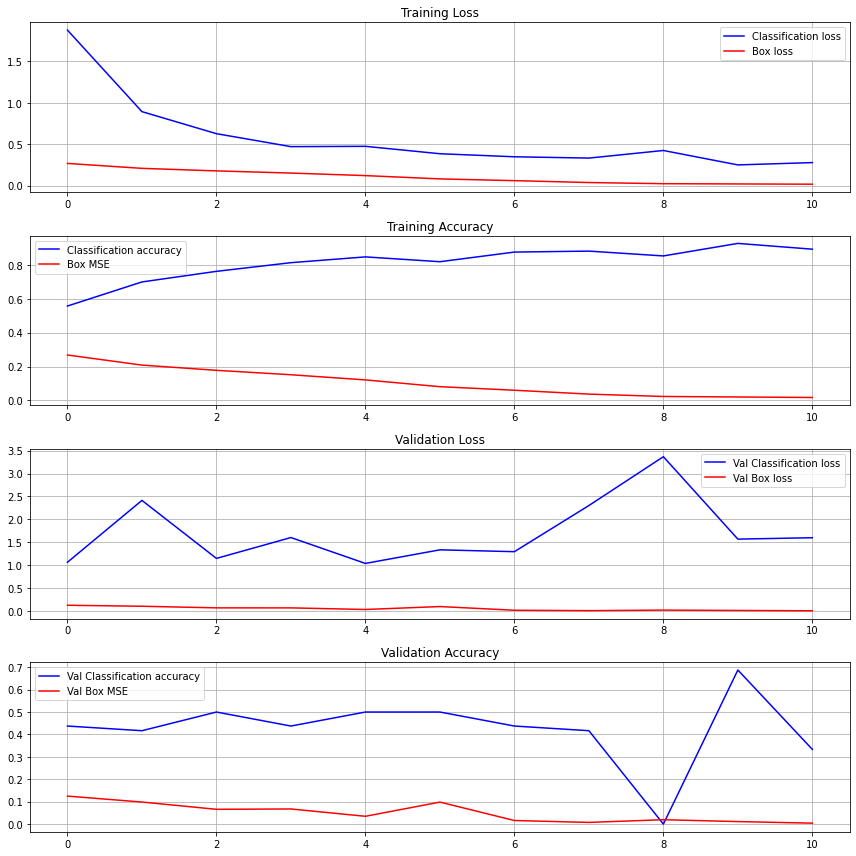

In [14]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,12))
ax1.plot(history.history['class_output_loss'],color='b',label='Classification loss')
ax1.plot(history.history['box_output_loss'],color='r',label='Box loss')
ax1.set_title('Training Loss')
ax2.plot(history.history['class_output_accuracy'],color='b',label='Classification accuracy')
ax2.plot(history.history['box_output_mse'],color='r',label='Box MSE')
ax2.set_title('Training Accuracy')
ax3.plot(history.history['val_class_output_loss'],color='b',label='Val Classification loss')
ax3.plot(history.history['val_box_output_loss'],color='r',label='Val Box loss')
ax3.set_title('Validation Loss')
ax4.plot(history.history['val_class_output_accuracy'],color='b',label='Val Classification accuracy')
ax4.plot(history.history['val_box_output_mse'],color='r',label='Val Box MSE')
ax4.set_title('Validation Accuracy')
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

In [15]:
# save the model
model.save('clmodel.h5')

Generate test generator

In [16]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
def generate_data_generator_test(generator, classes, box,directory,batch_size):
    classes = generator.flow_from_dataframe(dataframe = classes,
                                            directory = directory,
                                            x_col = 'class_name',
                                            y_col = 'class',
                                            target_size = (128,128),
                                            class_mode = 'categorical',
                                            batch_size = batch_size,
                                            shuffle=False)
    box = generator.flow_from_dataframe(dataframe = box,
                                        directory = directory,
                                        x_col = 'filename',
                                        y_col = ['ymin', 'ymax', 'xmin', 'xmax'],
                                        target_size = (128,128),
                                        class_mode = 'raw',
                                        batch_size = batch_size,
                                        shuffle=False)
    while True:
        Xi = classes.next()
        Xi2 = box.next()
        yield Xi[0],[Xi[1],Xi2[1]]

Visualize prediction

In [17]:
classification,box = model.predict_generator(generate_data_generator_test(test_datagen,
                                                                     img_test,
                                                                     annot_test,
                                                                     all_image_directory,
                                                                     batch_size),
                                                                     steps = (total_test/batch_size))
# get the highest probability output
label = np.argmax(classification,axis=-1)

Found 22 validated image filenames belonging to 3 classes.
Found 22 validated image filenames.


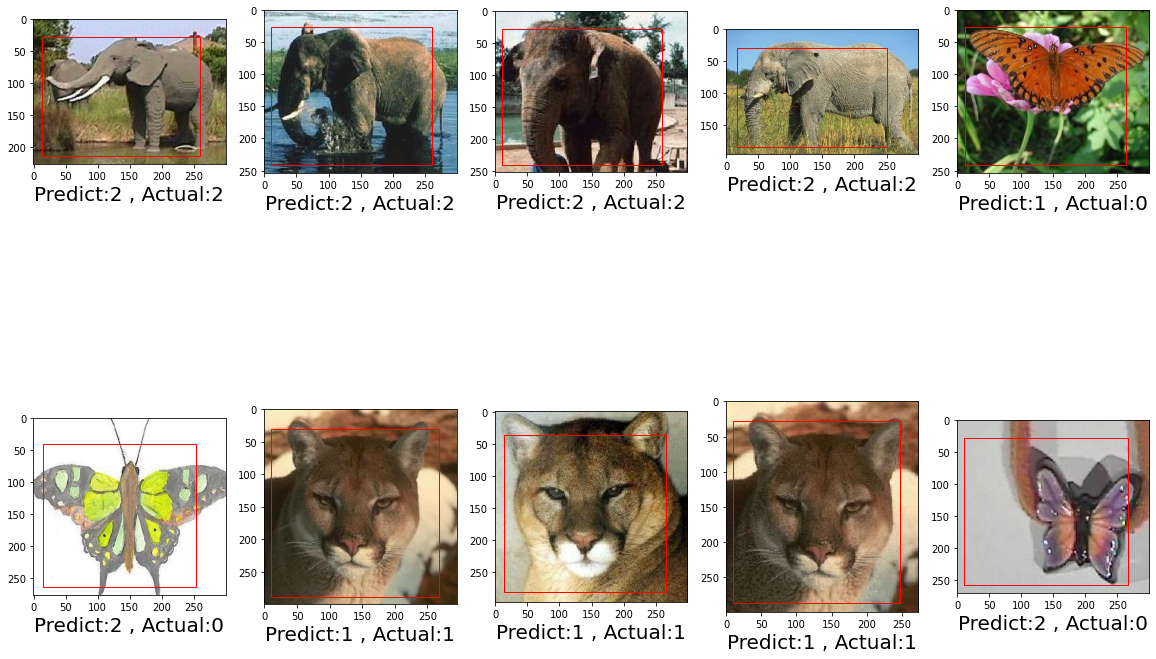

In [23]:
# visualize first ten samples
n = 10
images = img_test[:n]
plt.figure(figsize=(20,14))
for x in range(n):
    plt.subplot(2,5,x+1)
    img = cv2.imread(os.path.join(all_image_directory,img_test.iloc[x][0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ymin = int(box[x][0] * annot_test.iloc[x]['height'])
    ymax = int(box[x][1] * annot_test.iloc[x]['height'])
    xmin = int(box[x][2] * annot_test.iloc[x]['width'])
    xmax = int(box[x][3] * annot_test.iloc[x]['width'])
    rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),ec='r', fc='none')
    plt.gca().add_patch(rect)
    plt.xlabel('Predict:{} , Actual:{}'.format(label[x],img_test.iloc[x][1]),fontsize = 20)
    plt.imshow(img)